In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

In [9]:
neural_net = torch.nn.Sequential(nn.Linear(10, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 5))
Y = torch.randn(2,10)
neural_net(Y)

tensor([[-0.3708, -0.3772, -0.1146,  0.1786,  0.2537],
        [-0.3936, -0.5106, -0.1002, -0.0599,  0.2808]],
       grad_fn=<AddmmBackward0>)

In [14]:
# v = torch.randn(4, 2, 10)
# Y = torch.randint(0, 10, (4, 5, 10)).float()
# # print(v, Y)
# lik = Poisson_noise()
# model = LDS(v, Y, lik, x_dim=12)
# rec_model = RecognitionModel(model)
# rec_model.get_x_tilde(Y).shape

tensor([[[ 1.3550,  0.0617],
         [-0.8440, -0.1335]]], device='cuda:0') tensor([[[-1.0051, -0.5785],
         [ 0.0438, -1.6891]]], device='cuda:0')


torch.Size([4, 12, 10])

In [2]:
torch.manual_seed(1)
np.random.seed(1)
v = torch.randn(4, 2, 10)
# Y = torch.randn(4, 5, 10)
Y = torch.randint(0, 10, (4, 5, 10)).float()
# print(v, Y)
lik = Poisson_noise()
model = LDS(v, Y, lik)
# model.joint_LL(3)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001}
model.train_supervised_model(model.training_params(**train_params))

tensor([[[ 0.4728,  1.0049],
         [-0.2871, -1.1619]]], device='cuda:0') tensor([[[-0.6877, -0.5058],
         [ 0.1924,  0.7161]]], device='cuda:0')
step 0 LL -1474.0516357421875
step 1 LL -815.424560546875
step 2 LL -493.8179931640625
step 3 LL -415.11517333984375
step 4 LL -371.82843017578125
step 5 LL -336.625
step 6 LL -327.46405029296875
step 7 LL -300.5373229980469
step 8 LL -284.38165283203125
step 9 LL -287.5640869140625
step 10 LL -272.06103515625
step 11 LL -260.39984130859375
step 12 LL -255.66085815429688
step 13 LL -250.82667541503906
step 14 LL -235.3560333251953
step 15 LL -234.2386932373047
step 16 LL -227.18258666992188
step 17 LL -224.47540283203125
step 18 LL -219.06869506835938
step 19 LL -213.14361572265625
step 20 LL -209.90725708007812
step 21 LL -206.92672729492188
step 22 LL -209.43211364746094
step 23 LL -208.2082061767578
step 24 LL -203.35153198242188
step 25 LL -204.6104278564453
step 26 LL -205.30206298828125
step 27 LL -197.5394287109375
step 28 LL -

In [3]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001, 'n_mc_x': 100, 'n_mc_z': 100}
rec_model.train_recognition_model(rec_model.training_params(**train_params))

step 0 LL -156.75711059570312
step 1 LL -392.5568542480469
step 2 LL -167.86029052734375
step 3 LL -168.61451721191406
step 4 LL -193.71670532226562
step 5 LL -191.40599060058594
step 6 LL -179.25177001953125
step 7 LL -169.08973693847656
step 8 LL -162.88604736328125
step 9 LL -158.5609130859375
step 10 LL -157.21170043945312
step 11 LL -156.73541259765625
step 12 LL -156.1216583251953
step 13 LL -156.48065185546875
step 14 LL -155.78721618652344
step 15 LL -156.04034423828125
step 16 LL -156.12901306152344
step 17 LL -155.52249145507812
step 18 LL -154.93017578125
step 19 LL -155.26416015625
step 20 LL -155.0967559814453
step 21 LL -154.95530700683594
step 22 LL -154.5157470703125
step 23 LL -154.59878540039062
step 24 LL -154.37948608398438
step 25 LL -154.70632934570312
step 26 LL -153.97549438476562
step 27 LL -154.27261352539062
step 28 LL -154.05349731445312
step 29 LL -154.00833129882812
step 30 LL -154.15280151367188
step 31 LL -154.20040893554688
step 32 LL -154.1145935058593

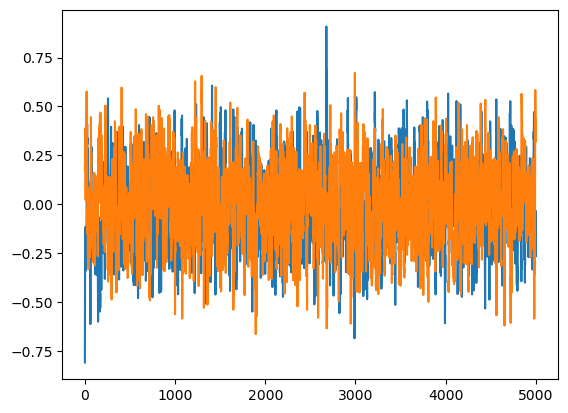

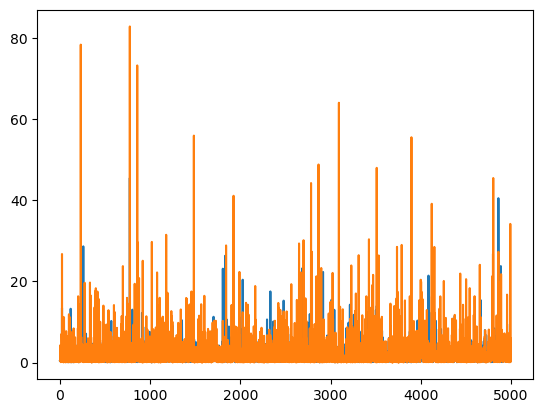

In [15]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 10
x_dim = 2

A = np.array([[0.9, 0.1], [-0.2, 0.8]])
B = np.array([[0.1, 0.0], [0.0, 0.1]])
W = np.array([[1, 0.0], [0.0, 1]])
C = np.random.randn(N, x_dim)
sigma_x = 0.5

mu0 = np.array([0., 0.])
Sigma0 = np.array([[.10, 0.0], [0.0, .10]])

v0 = np.random.multivariate_normal(mu0, Sigma0)

T = 5000
v = np.zeros((1,2,T))
x = np.zeros((1,x_dim,T))
v[0,:, 0] = v0
x[0,:, 0] = W @ v0 + sigma_x * np.random.randn(x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + B @ np.random.randn(2,)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(x_dim,)

plt.plot(v[0,0,:])
plt.plot(v[0,1,:])
plt.show()

F = C[None, ...] @ x

plt.plot(np.exp(F[0,0,:]))
plt.plot(np.exp(F[0,1,:]))
plt.show()


In [16]:
link_fn = torch.exp
lik = Poisson_noise()
Y = np.random.poisson(np.exp(F))

model = LDS(Tensor(v), Tensor(Y), lik, x_dim=x_dim, link_fn=link_fn)
train_params = {'batch_size': None, 'n_mc': 100}
model.train_supervised_model(model.training_params(**train_params))

tensor([[[ 1.5410, -0.2934],
         [-2.1788,  0.5684]]], device='cuda:0') tensor([[[-1.2904, -0.7911],
         [-0.0209, -0.7185]]], device='cuda:0')
step 0 LL -110211.8046875
step 1 LL -108206.5625
step 2 LL -106068.5859375
step 3 LL -103804.8359375
step 4 LL -101486.8359375
step 5 LL -99029.984375
step 6 LL -96541.6484375
step 7 LL -93759.9453125
step 8 LL -91645.40625
step 9 LL -89345.0078125
step 10 LL -87684.6484375
step 11 LL -86136.8828125
step 12 LL -85149.453125
step 13 LL -83737.890625
step 14 LL -83160.5390625
step 15 LL -82241.796875
step 16 LL -81595.421875
step 17 LL -80772.8671875
step 18 LL -79808.0234375
step 19 LL -78931.9453125
step 20 LL -77711.59375
step 21 LL -76255.3984375
step 22 LL -74773.2890625
step 23 LL -82508.7109375
step 24 LL -74493.25
step 25 LL -74031.859375
step 26 LL -74215.65625
step 27 LL -74386.359375
step 28 LL -74508.828125
step 29 LL -74482.625
step 30 LL -74449.15625
step 31 LL -74229.4296875
step 32 LL -74135.296875
step 33 LL -73935.0156

In [5]:
for prm in model.parameters():
    print(prm.shape, prm)

print(C)

torch.Size([1, 2, 2]) Parameter containing:
tensor([[[ 0.8918,  0.0873],
         [-0.2062,  0.7880]]], device='cuda:0', requires_grad=True)
torch.Size([1, 10, 2]) Parameter containing:
tensor([[[ 0.3070,  1.2588],
         [ 1.7376,  0.7049],
         [-0.6267,  1.4399],
         [-0.1059,  0.6292],
         [ 0.2796, -0.0367],
         [ 0.9751,  0.0903],
         [ 0.1346,  0.5161],
         [ 0.2263,  0.3434],
         [-0.0304,  1.0361],
         [-0.5163,  0.2287]]], device='cuda:0', requires_grad=True)
torch.Size([1, 2, 2]) Parameter containing:
tensor([[[-0.0445,  1.5215],
         [ 1.5756, -0.1309]]], device='cuda:0', requires_grad=True)
torch.Size([1, 2, 2]) Parameter containing:
tensor([[[-0.0364,  0.0918],
         [-0.0922, -0.0356]]], device='cuda:0', requires_grad=True)
torch.Size([1]) Parameter containing:
tensor([0.7538], device='cuda:0', requires_grad=True)
torch.Size([1, 2]) Parameter containing:
tensor([[-0.6181, -0.0286]], device='cuda:0', requires_grad=True)
torc

In [17]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001, 'n_mc_x': 100, 'n_mc_z': 100}
rec_model.train_recognition_model(rec_model.training_params(**train_params))

step 0 LL -92905.25
step 1 LL -631246.0
step 2 LL -94578.9140625
step 3 LL -97118.9921875
step 4 LL -112967.9765625
step 5 LL -120041.9609375
step 6 LL -120260.5234375
step 7 LL -117073.640625
step 8 LL -111946.59375
step 9 LL -106505.9453125
step 10 LL -101201.3671875
step 11 LL -97732.34375
step 12 LL -96063.515625
step 13 LL -96436.7109375
step 14 LL -96866.9609375
step 15 LL -96514.0703125
step 16 LL -95306.1640625
step 17 LL -93859.046875
step 18 LL -92684.4921875
step 19 LL -92045.6171875
step 20 LL -91894.4453125
step 21 LL -91962.828125
step 22 LL -92085.03125
step 23 LL -92265.6484375
step 24 LL -92215.0703125
step 25 LL -92129.6875
step 26 LL -92039.546875
step 27 LL -91887.6484375
step 28 LL -91721.5703125
step 29 LL -91597.7578125
step 30 LL -91553.3125
step 31 LL -91562.046875
step 32 LL -91686.0390625
step 33 LL -91801.5859375
step 34 LL -91763.71875
step 35 LL -91648.5078125
step 36 LL -91544.59375
step 37 LL -91561.03125
step 38 LL -91409.3359375
step 39 LL -91419.53125

KeyboardInterrupt: 

In [6]:
# # Natural parameters for p(v_t|v_{t-1})
# mus = self.A @ v[... , :-1] # (ntrials, b, T-1)
# # print(mu.shape, self.Q.shape)
# second_big = torch.zeros(ntrials).to(device)
# for t in range(T-1): # TODO, can we vectorize this?
#     dist = MultivariateNormal(mus[..., t], self.Q)
#     second_big += dist.log_prob(v[..., t+1])

# # # Replace the for loop with this code
# # dist = MultivariateNormal(mus, self.Q[..., None])
# # second_big = dist.log_prob(v[..., 1:]).sum(dim=-1)

mus = torch.zeros(4, 2, 9)
Q = torch.eye(2)[None, ...]
# Q = Q.expand(4, -1, -1)
v = torch.zeros(4, 2, 10)
print(mus.shape, Q.shape)

T = 10
second_big = torch.zeros(4)
for t in range(T-1): # TODO, can we vectorize this?
    print(mus[..., t].shape, Q.shape)
    dist = MultivariateNormal(mus[..., t], Q)
    second_big += dist.log_prob(v[..., t+1])

print(second_big.shape, second_big)

# Replace the for loop with this code
# dist = MultivariateNormal(mus, Q[..., None].expand(-1, -1, -1, mus.shape[-1]))
# second_big = dist.log_prob(v[..., 1:]).sum(dim=-1)
# print(second_big.shape, second_big)
# mus = mus.transpose(-1,-2)
# print(mus.shape)
mus = mus.transpose(-1,-2)
# Q = Q[:, None, ...].expand(-1, mus.shape[1], -1, -1)
Q = Q[:, None, ...]
print(Q.shape, mus.shape)
dist = MultivariateNormal(mus, Q)
v = v[..., 1:].transpose(-1,-2)
print(v.shape)
second_big = dist.log_prob(v).sum(dim=-1)
print(second_big.shape, second_big)


torch.Size([4, 2, 9]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4]) tensor([-16.5409, -16.5409, -16.5409, -16.5409])
torch.Size([1, 1, 2, 2]) torch.Size([4, 9, 2])
torch.Size([4, 9, 2])
torch.Size([4]) tensor([-16.5409, -16.5409, -16.5409, -16.5409])


In [9]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
data_len = 1000 # number of time bins to use for fitting
timepoints = np.arange(0, data_len) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
# Y_test = Y[..., 1000:] # hold out some data for testing
# Y = Y[..., :1000] # use first 1000 time bins for training
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)


(1, 200, 70482)
(1, 102, 1000)


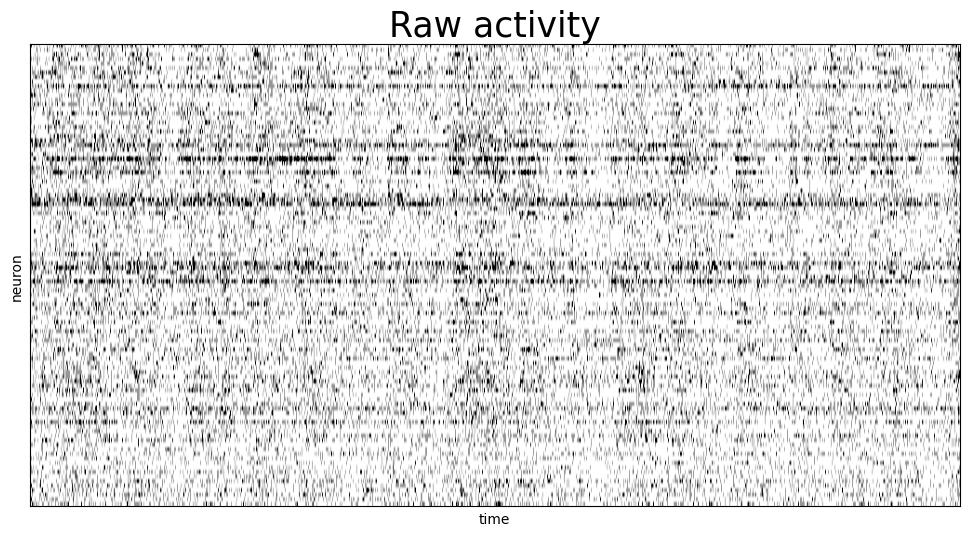

In [10]:
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

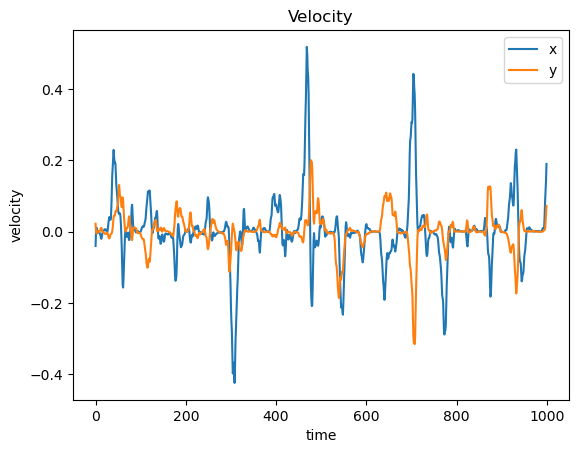

(1, 102, 1000) (1000, 2)


In [11]:
plt.plot(vels[:, 0], label = 'x')
plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity', fontsize = 12)
plt.show()

print(Y.shape, vels.shape)

In [12]:
link_fn = torch.exp
lik = Poisson_noise()
v = vels.T[None, ...]
print(v.shape)

model = LDS(Tensor(v), Tensor(Y), lik, link_fn=link_fn)
train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 7.5e-2}
model.train_supervised_model(model.training_params(**train_params))


(1, 2, 1000)
tensor([[[[[-0.2095,  2.0755,  0.9741,  ...,  0.6964, -0.5130, -0.2222],
           [-0.4379,  3.9175,  0.0367,  ...,  1.3105, -0.6499, -0.3573],
           [-0.1440,  1.5292,  1.1587,  ...,  0.5140, -0.4559, -0.1789],
           ...,
           [-0.2024,  1.5738, -1.1123,  ...,  0.5240, -0.0619, -0.1047],
           [-0.2101,  1.9151,  0.1870,  ...,  0.6410, -0.3476, -0.1805],
           [-0.2711,  1.9486, -2.2453,  ...,  0.6469,  0.0768, -0.0997]]]],



        [[[[ 1.1848,  0.2577, -0.9318,  ..., -0.3411, -1.6847,  1.1160],
           [ 1.6701,  0.8560, -0.9003,  ..., -0.1474, -3.5689,  2.3628],
           [ 1.0115,  0.0995, -0.8966,  ..., -0.3728, -1.1461,  0.7595],
           ...,
           [ 0.3167,  0.5750,  0.1752,  ...,  0.2513, -1.6769,  1.1095],
           [ 0.8695,  0.3838, -0.5207,  ..., -0.1186, -1.7082,  1.1310],
           [ 0.1194,  0.8899,  0.6305,  ...,  0.5504, -2.2636,  1.4972]]]],



        [[[[ 0.3152,  0.6197,  1.6606,  ..., -0.9426,  1.4765,  1.0

KeyboardInterrupt: 

In [8]:
for prm in model.parameters():
    print(prm.shape, prm)

torch.Size([1, 2, 2]) Parameter containing:
tensor([[[ 0.9112, -0.1650],
         [ 0.0511,  0.9810]]], device='cuda:0', requires_grad=True)
torch.Size([1, 102, 2]) Parameter containing:
tensor([[[-0.4278, -0.7628],
         [ 0.1148,  0.0361],
         [-0.1376,  0.7470],
         [ 0.5418,  0.0489],
         [-0.0429,  0.5085],
         [ 0.6402, -0.0609],
         [-0.6016,  0.9485],
         [-0.1952, -0.2081],
         [-0.5491, -0.0138],
         [-0.1958, -0.3812],
         [ 0.0131,  0.4363],
         [ 0.6242, -0.0754],
         [ 0.2493, -0.1266],
         [-0.3220,  0.1072],
         [-0.2606, -0.8447],
         [ 0.1671, -0.1791],
         [-0.0483,  0.1736],
         [-0.2839, -0.2483],
         [ 0.8077,  0.5693],
         [-0.3655,  0.1580],
         [ 1.0601,  0.9951],
         [ 0.2086, -0.1637],
         [-0.4318,  0.3638],
         [ 0.9580,  0.4147],
         [-0.2443,  0.1171],
         [-0.9343, -0.1477],
         [ 0.1164,  0.9021],
         [-0.0077,  0.3583],
 

In [9]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001, 'n_mc_x': 50, 'n_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))

step 0 LL -174433.28125
step 1 LL -477226.84375
step 2 LL -1423177.0
step 3 LL -178737.765625
step 4 LL -154068.84375
step 5 LL -157319.71875
step 6 LL -222075.375
step 7 LL -256683.15625
step 8 LL -169340.59375
step 9 LL -173876.734375
step 10 LL -190114.453125
step 11 LL -144275.515625
step 12 LL -174936.34375
step 13 LL -160528.21875
step 14 LL -142378.53125
step 15 LL -152339.546875
step 16 LL -140744.15625
step 17 LL -148302.109375
step 18 LL -134531.375
step 19 LL -136806.75
step 20 LL -138915.40625
step 21 LL -122486.5859375
step 22 LL -132968.5
step 23 LL -130024.203125
step 24 LL -125396.3203125
step 25 LL -127813.203125
step 26 LL -126876.0703125
step 27 LL -128566.078125
step 28 LL -119403.3203125
step 29 LL -127095.1015625
step 30 LL -123099.578125
step 31 LL -120064.6953125
step 32 LL -123771.1328125
step 33 LL -121897.515625
step 34 LL -123826.9453125
step 35 LL -120216.6484375
step 36 LL -121654.1328125
step 37 LL -120156.921875
step 38 LL -119490.6328125
step 39 LL -121

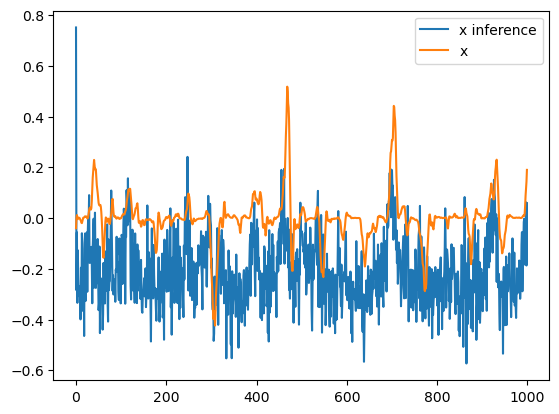

In [24]:
z = rec_model.test_z(rec_model.gen_model.Y)
z = z.detach().cpu().numpy()
plt.plot(z[0,0,:], label = 'x inference')
# plt.plot(z[0,1,:], label = 'y inference')
plt.plot(vels[:, 0], label = 'x')
# plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

In [2]:
# Train 4G10 model
z = np.load('4G10_z.npy')
z = z.transpose(1,0, 2)
print(z.shape)
z = torch.Tensor(z)

Y_train = np.load('neural_train.npy')
Y_train = Y_train.transpose(1,0,2)
Y_train = torch.Tensor(Y_train)
print(Y_train.shape)

Y_test = np.load('neural_test.npy')
Y_test = Y_test.transpose(1,0,2)
Y_test = torch.Tensor(Y_test)
print(Y_test.shape)

(400, 10, 16)
torch.Size([400, 162, 16])
torch.Size([100, 162, 16])


In [3]:
np.random.seed(0)
torch.manual_seed(0)
link_fn = torch.functional.F.softplus
# link_fn = torch.exp
lik = Poisson_noise()
model = LDS(z, Y_train, lik, link_fn=link_fn)
print(model.N, model.T, model.x_dim, model.b, model.ntrials)
train_params = {'batch_size': None, 'n_mc': 1, 'lrate': 7.5e-2}
model.train_supervised_model(model.training_params(**train_params))

162 16 10 10 400
step 0 LL -565967.375
step 1 LL -106810.71875
step 2 LL -59483.76953125
step 3 LL -38398.3359375
step 4 LL -27844.57421875
step 5 LL -22192.8671875
step 6 LL -19165.435546875
step 7 LL -17571.7109375
step 8 LL -16867.529296875
step 9 LL -16560.888671875
step 10 LL -16359.9482421875
step 11 LL -15978.9150390625
step 12 LL -15362.439453125
step 13 LL -14542.6162109375
step 14 LL -13778.73828125
step 15 LL -13176.4521484375
step 16 LL -12620.1298828125
step 17 LL -12047.03515625
step 18 LL -11475.2724609375
step 19 LL -10953.732421875
step 20 LL -10491.1533203125
step 21 LL -10052.5
step 22 LL -9627.3212890625
step 23 LL -9228.6787109375
step 24 LL -8969.4853515625
step 25 LL -8656.5927734375
step 26 LL -8494.5048828125
step 27 LL -8342.6044921875
step 28 LL -8159.72021484375
step 29 LL -7941.95849609375
step 30 LL -7737.60498046875
step 31 LL -7590.78271484375
step 32 LL -7491.26220703125
step 33 LL -7382.5
step 34 LL -7253.30615234375
step 35 LL -7103.2373046875
step 36

In [4]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001, 'n_mc_x': 50, 'n_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))

ValueError: Expected parameter covariance_matrix (Tensor of shape (16, 16, 10, 10)) of distribution MultivariateNormal(loc: torch.Size([16, 16, 10]), covariance_matrix: torch.Size([16, 16, 10, 10])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[[ 13.4832,  -7.6674,   8.4452,  ...,  -9.8051,  -6.0587, -10.3296],
          [ -7.6674,   8.4517,  -7.4515,  ...,   9.2010,   8.5952,   8.1201],
          [  8.4452,  -7.4515,  11.7812,  ...,  -7.5777,  -5.3780,  -4.6451],
          ...,
          [ -9.8051,   9.2010,  -7.5777,  ...,  15.6360,  10.2602,  13.1976],
          [ -6.0587,   8.5952,  -5.3780,  ...,  10.2602,  10.7022,   9.0381],
          [-10.3296,   8.1201,  -4.6451,  ...,  13.1976,   9.0381,  14.7045]],

         [[ 13.4832,  -7.6674,   8.4452,  ...,  -9.8051,  -6.0587, -10.3296],
          [ -7.6674,   8.4517,  -7.4515,  ...,   9.2010,   8.5952,   8.1201],
          [  8.4452,  -7.4515,  11.7812,  ...,  -7.5777,  -5.3780,  -4.6451],
          ...,
          [ -9.8051,   9.2010,  -7.5777,  ...,  15.6360,  10.2602,  13.1976],
          [ -6.0587,   8.5952,  -5.3780,  ...,  10.2602,  10.7022,   9.0381],
          [-10.3296,   8.1201,  -4.6451,  ...,  13.1976,   9.0381,  14.7045]],

         [[ 13.4832,  -7.6674,   8.4452,  ...,  -9.8051,  -6.0587, -10.3296],
          [ -7.6674,   8.4517,  -7.4515,  ...,   9.2010,   8.5952,   8.1201],
          [  8.4452,  -7.4515,  11.7812,  ...,  -7.5777,  -5.3780,  -4.6451],
          ...,
          [ -9.8051,   9.2010,  -7.5777,  ...,  15.6360,  10.2602,  13.1976],
          [ -6.0587,   8.5952,  -5.3780,  ...,  10.2602,  10.7022,   9.0381],
          [-10.3296,   8.1201,  -4.6451,  ...,  13.1976,   9.0381,  14.7045]],

         ...,

         [[ 13.4832,  -7.6674,   8.4452,  ...,  -9.8051,  -6.0587, -10.3296],
          [ -7.6674,   8.4517,  -7.4515,  ...,   9.2010,   8.5952,   8.1201],
          [  8.4452,  -7.4515,  11.7812,  ...,  -7.5777,  -5.3780,  -4.6451],
          ...,
          [ -9.8051,   9.2010,  -7.5777,  ...,  15.6360,  10.2602,  13.1976],
          [ -6.0587,   8.5952,  -5.3780,  ...,  10.2602,  10.7022,   9.0381],
          [-10.3296,   8.1201,  -4.6451,  ...,  13.1976,   9.0381,  14.7045]],

         [[ 13.4832,  -7.6674,   8.4452,  ...,  -9.8051,  -6.0587, -10.3296],
          [ -7.6674,   8.4517,  -7.4515,  ...,   9.2010,   8.5952,   8.1201],
          [  8.4452,  -7.4515,  11.7812,  ...,  -7.5777,  -5.3780,  -4.6451],
          ...,
          [ -9.8051,   9.2010,  -7.5777,  ...,  15.6360,  10.2602,  13.1976],
          [ -6.0587,   8.5952,  -5.3780,  ...,  10.2602,  10.7022,   9.0381],
          [-10.3296,   8.1201,  -4.6451,  ...,  13.1976,   9.0381,  14.7045]],

         [[ 13.4832,  -7.6674,   8.4452,  ...,  -9.8051,  -6.0587, -10.3296],
          [ -7.6674,   8.4517,  -7.4515,  ...,   9.2010,   8.5952,   8.1201],
          [  8.4452,  -7.4515,  11.7812,  ...,  -7.5777,  -5.3780,  -4.6451],
          ...,
          [ -9.8051,   9.2010,  -7.5777,  ...,  15.6360,  10.2602,  13.1976],
          [ -6.0587,   8.5952,  -5.3780,  ...,  10.2602,  10.7022,   9.0381],
          [-10.3296,   8.1201,  -4.6451,  ...,  13.1976,   9.0381,  14.7045]]],


        [[[  1.4560,  -0.7896,  -0.8572,  ...,   0.8779,  -0.3417,   0.1895],
          [ -0.7902,   0.4776,   0.4015,  ...,  -0.5006,   0.1240,  -0.0935],
          [ -0.8561,   0.4006,   0.6484,  ...,  -0.4760,   0.3255,  -0.1395],
          ...,
          [  0.8782,  -0.5004,  -0.4768,  ...,   0.5597,  -0.1634,   0.0994],
          [ -0.3407,   0.1232,   0.3251,  ...,  -0.1627,   0.2212,  -0.0891],
          [  0.1894,  -0.0933,  -0.1396,  ...,   0.0993,  -0.0892,   0.0718]],

         [[  1.4560,  -0.7896,  -0.8572,  ...,   0.8779,  -0.3417,   0.1895],
          [ -0.7902,   0.4776,   0.4015,  ...,  -0.5006,   0.1240,  -0.0935],
          [ -0.8561,   0.4006,   0.6484,  ...,  -0.4760,   0.3255,  -0.1395],
          ...,
          [  0.8782,  -0.5004,  -0.4768,  ...,   0.5597,  -0.1634,   0.0994],
          [ -0.3407,   0.1232,   0.3251,  ...,  -0.1627,   0.2212,  -0.0891],
          [  0.1894,  -0.0933,  -0.1396,  ...,   0.0993,  -0.0892,   0.0718]],

         [[  1.4560,  -0.7896,  -0.8572,  ...,   0.8779,  -0.3417,   0.1895],
          [ -0.7902,   0.4776,   0.4015,  ...,  -0.5006,   0.1240,  -0.0935],
          [ -0.8561,   0.4006,   0.6484,  ...,  -0.4760,   0.3255,  -0.1395],
          ...,
          [  0.8782,  -0.5004,  -0.4768,  ...,   0.5597,  -0.1634,   0.0994],
          [ -0.3407,   0.1232,   0.3251,  ...,  -0.1627,   0.2212,  -0.0891],
          [  0.1894,  -0.0933,  -0.1396,  ...,   0.0993,  -0.0892,   0.0718]],

         ...,

         [[  1.4560,  -0.7896,  -0.8572,  ...,   0.8779,  -0.3417,   0.1895],
          [ -0.7902,   0.4776,   0.4015,  ...,  -0.5006,   0.1240,  -0.0935],
          [ -0.8561,   0.4006,   0.6484,  ...,  -0.4760,   0.3255,  -0.1395],
          ...,
          [  0.8782,  -0.5004,  -0.4768,  ...,   0.5597,  -0.1634,   0.0994],
          [ -0.3407,   0.1232,   0.3251,  ...,  -0.1627,   0.2212,  -0.0891],
          [  0.1894,  -0.0933,  -0.1396,  ...,   0.0993,  -0.0892,   0.0718]],

         [[  1.4560,  -0.7896,  -0.8572,  ...,   0.8779,  -0.3417,   0.1895],
          [ -0.7902,   0.4776,   0.4015,  ...,  -0.5006,   0.1240,  -0.0935],
          [ -0.8561,   0.4006,   0.6484,  ...,  -0.4760,   0.3255,  -0.1395],
          ...,
          [  0.8782,  -0.5004,  -0.4768,  ...,   0.5597,  -0.1634,   0.0994],
          [ -0.3407,   0.1232,   0.3251,  ...,  -0.1627,   0.2212,  -0.0891],
          [  0.1894,  -0.0933,  -0.1396,  ...,   0.0993,  -0.0892,   0.0718]],

         [[  1.4560,  -0.7896,  -0.8572,  ...,   0.8779,  -0.3417,   0.1895],
          [ -0.7902,   0.4776,   0.4015,  ...,  -0.5006,   0.1240,  -0.0935],
          [ -0.8561,   0.4006,   0.6484,  ...,  -0.4760,   0.3255,  -0.1395],
          ...,
          [  0.8782,  -0.5004,  -0.4768,  ...,   0.5597,  -0.1634,   0.0994],
          [ -0.3407,   0.1232,   0.3251,  ...,  -0.1627,   0.2212,  -0.0891],
          [  0.1894,  -0.0933,  -0.1396,  ...,   0.0993,  -0.0892,   0.0718]]],


        [[[  0.7812,  -0.4473,  -0.4076,  ...,   0.4846,  -0.1335,   0.0898],
          [ -0.4475,   0.3007,   0.1792,  ...,  -0.2988,   0.0240,  -0.0441],
          [ -0.4073,   0.1789,   0.3376,  ...,  -0.2183,   0.1757,  -0.0704],
          ...,
          [  0.4846,  -0.2988,  -0.2185,  ...,   0.3289,  -0.0458,   0.0423],
          [ -0.1331,   0.0238,   0.1756,  ...,  -0.0456,   0.1461,  -0.0555],
          [  0.0897,  -0.0441,  -0.0704,  ...,   0.0422,  -0.0555,   0.0559]],

         [[  0.7812,  -0.4473,  -0.4076,  ...,   0.4846,  -0.1335,   0.0898],
          [ -0.4475,   0.3007,   0.1792,  ...,  -0.2988,   0.0240,  -0.0441],
          [ -0.4073,   0.1789,   0.3376,  ...,  -0.2183,   0.1757,  -0.0704],
          ...,
          [  0.4846,  -0.2988,  -0.2185,  ...,   0.3289,  -0.0458,   0.0423],
          [ -0.1331,   0.0238,   0.1756,  ...,  -0.0456,   0.1461,  -0.0555],
          [  0.0897,  -0.0441,  -0.0704,  ...,   0.0422,  -0.0555,   0.0559]],

         [[  0.7812,  -0.4473,  -0.4076,  ...,   0.4846,  -0.1335,   0.0898],
          [ -0.4475,   0.3007,   0.1792,  ...,  -0.2988,   0.0240,  -0.0441],
          [ -0.4073,   0.1789,   0.3376,  ...,  -0.2183,   0.1757,  -0.0704],
          ...,
          [  0.4846,  -0.2988,  -0.2185,  ...,   0.3289,  -0.0458,   0.0423],
          [ -0.1331,   0.0238,   0.1756,  ...,  -0.0456,   0.1461,  -0.0555],
          [  0.0897,  -0.0441,  -0.0704,  ...,   0.0422,  -0.0555,   0.0559]],

         ...,

         [[  0.7812,  -0.4473,  -0.4076,  ...,   0.4846,  -0.1335,   0.0898],
          [ -0.4475,   0.3007,   0.1792,  ...,  -0.2988,   0.0240,  -0.0441],
          [ -0.4073,   0.1789,   0.3376,  ...,  -0.2183,   0.1757,  -0.0704],
          ...,
          [  0.4846,  -0.2988,  -0.2185,  ...,   0.3289,  -0.0458,   0.0423],
          [ -0.1331,   0.0238,   0.1756,  ...,  -0.0456,   0.1461,  -0.0555],
          [  0.0897,  -0.0441,  -0.0704,  ...,   0.0422,  -0.0555,   0.0559]],

         [[  0.7812,  -0.4473,  -0.4076,  ...,   0.4846,  -0.1335,   0.0898],
          [ -0.4475,   0.3007,   0.1792,  ...,  -0.2988,   0.0240,  -0.0441],
          [ -0.4073,   0.1789,   0.3376,  ...,  -0.2183,   0.1757,  -0.0704],
          ...,
          [  0.4846,  -0.2988,  -0.2185,  ...,   0.3289,  -0.0458,   0.0423],
          [ -0.1331,   0.0238,   0.1756,  ...,  -0.0456,   0.1461,  -0.0555],
          [  0.0897,  -0.0441,  -0.0704,  ...,   0.0422,  -0.0555,   0.0559]],

         [[  0.7812,  -0.4473,  -0.4076,  ...,   0.4846,  -0.1335,   0.0898],
          [ -0.4475,   0.3007,   0.1792,  ...,  -0.2988,   0.0240,  -0.0441],
          [ -0.4073,   0.1789,   0.3376,  ...,  -0.2183,   0.1757,  -0.0704],
          ...,
          [  0.4846,  -0.2988,  -0.2185,  ...,   0.3289,  -0.0458,   0.0423],
          [ -0.1331,   0.0238,   0.1756,  ...,  -0.0456,   0.1461,  -0.0555],
          [  0.0897,  -0.0441,  -0.0704,  ...,   0.0422,  -0.0555,   0.0559]]],


        ...,


        [[[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         ...,

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]]],


        [[[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         ...,

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]]],


        [[[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         ...,

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]],

         [[  0.7558,  -0.4314,  -0.3962,  ...,   0.4680,  -0.1312,   0.0873],
          [ -0.4316,   0.2907,   0.1722,  ...,  -0.2885,   0.0227,  -0.0426],
          [ -0.3957,   0.1718,   0.3322,  ...,  -0.2109,   0.1744,  -0.0691],
          ...,
          [  0.4682,  -0.2884,  -0.2112,  ...,   0.3181,  -0.0444,   0.0407],
          [ -0.1307,   0.0224,   0.1742,  ...,  -0.0441,   0.1456,  -0.0552],
          [  0.0872,  -0.0425,  -0.0691,  ...,   0.0406,  -0.0552,   0.0557]]]],
       device='cuda:0')